In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle

import librosa
import librosa.display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential, load_model
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from datetime import datetime

In [99]:
n_mfcc = 12

labelled_data_path = '/Users/rym.laabiyad/RogerVoice/data_1s/labelled/'
feature_engineering_path = '/Users/rym.laabiyad/RogerVoice/data_1s/feature_engineering/'
models_path = '/Users/rym.laabiyad/RogerVoice/models/'

librosa_features_filename = '4labels_librosa_features_' + str(n_mfcc) + '_mfcc.pkl'
amplitude_features_filename = '4labels_amplitude.pkl'

scaler_filename = 'scaler.pkl'

model_xgb_filename = '3labels_model_xgb_1s_mfcc_' + str(n_mfcc) + '_and_chroma_and_amplitude.sav'
model_rf_filename = '3labels_model_rf_1s_mfcc_' + str(n_mfcc) + '_and_chroma_and_amplitude.sav'
model_cnn_2d_filename = '3labels_model_cnn4_1s_mfcc_' + str(n_mfcc) + '_and_chroma_2d.sav'

compute_2d_mfcc_chroma = True

train_models = False

labels_dict = {0: 'neutral', 1: 'neutral/happy', 2: 'inaudible', 3: 'sad', 4: 'angry'}

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

Retrieve the pre-trained 3-class classifiers (Neutral/Positive, Inaudible, Negative)

In [15]:
model_xgb = pickle.load(open(os.path.join(models_path, model_xgb_filename), 'rb'))
model_rf = pickle.load(open(os.path.join(models_path, model_rf_filename), 'rb'))
model_cnn_2d = load_model(os.path.join(models_path, model_cnn_2d_filename))

Retrieve the features and the labels (Neutral, Happy, Inaudible, Sad, Angry) from our recordings

In [100]:
recordings_librosa = pd.read_pickle(os.path.join(feature_engineering_path, librosa_features_filename))
recordings_amplitude = pd.read_pickle(os.path.join(feature_engineering_path, amplitude_features_filename))

recordings_with_features = recordings_librosa.iloc[:,:26].merge(recordings_amplitude.drop('labels', axis=1), 
                                                  on='paths')

unique, counts = np.unique(recordings_with_features.labels, return_counts=True)
print(dict(zip(unique, counts)))

{1.0: 4253, 2.0: 579, 3.0: 1313, 4.0: 1413}


In [102]:
def reduce_class(recordings, biggest_class, ideal_class, seed=42):
    np.random.seed(seed)
    
    recordings_biggest_class = recordings[recordings.labels == biggest_class].index.tolist()
    recordings_ideal_class = recordings[recordings.labels == ideal_class].index.tolist()
    
    to_drop = np.random.choice(recordings_biggest_class, 
                               len(recordings_biggest_class)-len(recordings_ideal_class),
                               False)
    recordings.drop(index=to_drop, inplace=True)
        
    return recordings


def augment_class(recordings, label):
    inaudible = recordings[recordings.labels == label]
    recordings = pd.concat([recordings, inaudible], axis=0, ignore_index=True)
    
    return recordings


def balance_classes(recordings, seed=42):
    recordings = reduce_class(recordings, 1, 4, seed)
    recordings = augment_class(recordings, 2)
    return recordings


def prepare_data(X, y, test_size=0.2, random_state=42, scale=False):
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        pickle.dump(scaler, open(os.path.join(feature_engineering_path, scaler_filename), 'wb')) 
        X = scaler.transform(X)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state)    
    return X_train, X_test, y_train, y_test

In [103]:
recordings_with_features = balance_classes(recordings_with_features)
recordings = recordings_with_features.iloc[:,:2]

unique, counts = np.unique(recordings_with_features.labels, return_counts=True)
print('Labels distribution:', dict(zip(unique, counts)))

Labels distribution: {1.0: 1413, 2.0: 1158, 3.0: 1313, 4.0: 1413}


In [104]:
def extract_2d_features(path, root_data_path, n_mfcc=12, chroma=False):
    audio_data, sample_rate = librosa.load(os.path.join(root_data_path, path))
    
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    
    if chroma:
        stft = np.abs(librosa.stft(audio_data))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    
        return np.concatenate([mfcc, chroma])
    else:
        return mfcc

In [105]:
def get_predictions_from_probas(probas, n_labels):
    if n_labels < 5:
        predictions = [p+1 for p in probas.argmax(axis=1)]
    else:
        predictions = probas.argmax(axis=1)
        
    return predictions


def train_model(model, params, X_train, y_train, models_path, model_filename):
    model = GridSearchCV(model, params, cv=5, n_jobs=-1)
    model.fit(X_train, y_train)

    # save the model to disk
    pickle.dump(model, open(os.path.join(models_path, model_filename), 'wb'))
    return model


def evaluate_model(model, X_test, y_test, proba):
    print('Accuracy of the model: {}'.format(model.score(X_test, y_test)))
    
    if proba:
        probas = model.predict_proba(X_test)
        preds = get_predictions_from_probas(probas)

        print(confusion_matrix(y_test, preds))
        res = pd.DataFrame({'real':y_test, 'predicted': preds})
        res = pd.concat([res, pd.DataFrame(100*probas)], axis=1, ignore_index=True)
        res.columns = np.concatenate([['real', 'predicted'], 
                                         [reverse_labels_dict[int(label)] for label in np.unique(y_train)]])
    else:
        preds = model.predict(X_test)
        print(confusion_matrix(y_test, preds))
        res = pd.DataFrame({'real':y_test, 'predicted':preds})
        

def plot_cv_results(model, param_name, param_values, plot_title=''):
    cv_results = pd.DataFrame(model.cv_results_)
    scores = np.array(cv_results['mean_test_score']).reshape(len(param_values))

    plt.plot(param_values, scores)
    plt.xlabel(param_name)
    plt.ylabel('Average accuracy')
    plt.title(plot_title)
    plt.show()
    
def compare_one_row_results(row, col1, col2):
    if row[col1] == row[col2]:
        return 1
    else:
        return 0
    
def compare_two_columns(predictions, col1, col2):
    result = predictions.apply(compare_one_row_results, axis=1, args=(col1, col2))
    return sum(result)/len(result)

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def compare_results(predictions, remove_path=True):
    if remove_path:
        cols = predictions.columns[1:]
    else:
        cols = predictions.columns
        
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            print(cols[i], '-', cols[j], ':', 
                  100*compare_two_columns(predictions, cols[i], cols[j]), '% similar')  

In [106]:
def make_cnn(n_labels, n_features, size_recordings_2d=44, input_dimension=1):
    model = Sequential()
    
    if input_dimension == 1:
        #1st convolutional layer
        model.add(Conv1D(128, 5, padding='same', activation='relu',
                         input_shape=(n_features, 1)))
        #2nd convolutional layer
        model.add(Conv1D(128, 5, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=(6)))
        #3rd convolutional layer
        model.add(Conv1D(256, 5, padding='same', activation='relu'))
        model.add(Dropout(0.3))
        #4th convolutional layer
        model.add(Conv1D(256, 5, padding='same', activation='relu'))
        
    else:
        #1st convolutional layer
        model.add(Conv2D(128, 5, padding='same', activation='relu',
                         input_shape=(n_features, size_recordings_2d, 1)))
        #2nd convolutional layer
        model.add(Conv2D(128, 5, padding='same', activation='relu'))
        model.add(MaxPooling2D())
        #3rd convolutional layer
        model.add(Conv2D(256, 5, padding='same', activation='relu'))
        model.add(Dropout(0.3))
        #4th convolutional layer
        model.add(Conv2D(256, 5, padding='same', activation='relu'))
        
   #Final connected layer 
    model.add(Flatten())
    model.add(Dense(n_labels))
    model.add(Activation('softmax'))
    
    return model


def plot_model_history(history, plot_title='model loss'):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(plot_title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [107]:
negative_recordings = recordings_with_features[(recordings_with_features.labels == 3) | (recordings_with_features.labels == 4)]
X_negative = np.array(negative_recordings.iloc[:,2:])
y_negative = np.array(negative_recordings.iloc[:,1])
X_negative_train, X_negative_test, y_negative_train, y_negative_test = prepare_data(X_negative, y_negative)

positive_recordings = recordings_with_features[(recordings_with_features.labels == 0) | (recordings_with_features.labels == 1)]
X_positive = np.array(positive_recordings.iloc[:,2:])
y_positive = np.array(positive_recordings.iloc[:,1])
X_positive_train, X_positive_test, y_positive_train, y_positive_test = prepare_data(X_positive, y_positive)

In [41]:
if compute_2d_mfcc_chroma:
    start = datetime.now()
    
    # Negative emotions
    negative_features_mfcc_chroma = negative_recordings.paths.apply(extract_2d_features, 
                                                                    args=(labelled_data_path, n_mfcc, True)).values    
    negative_features_2d_mfcc_chroma = np.zeros((negative_features_mfcc_chroma.shape[0], 
                                                 negative_features_mfcc_chroma[0].shape[0], 
                                                 negative_features_mfcc_chroma[0].shape[1]))
    for i in range(negative_features_mfcc_chroma.shape[0]):
        negative_features_2d_mfcc_chroma[i] = negative_features_mfcc_chroma[i]
    print(negative_features_2d_mfcc_chroma.shape)
    
    # Positive emotions
    positive_features_mfcc_chroma = positive_recordings.paths.apply(extract_2d_features, 
                                                                    args=(labelled_data_path, n_mfcc, True)).values    
    positive_features_2d_mfcc_chroma = np.zeros((positive_features_mfcc_chroma.shape[0], 
                                                 positive_features_mfcc_chroma[0].shape[0], 
                                                 positive_features_mfcc_chroma[0].shape[1]))
    for i in range(positive_features_mfcc_chroma.shape[0]):
        positive_features_2d_mfcc_chroma[i] = positive_features_mfcc_chroma[i]

    print(positive_features_2d_mfcc_chroma.shape)
    
    print('Extracting features took {}'.format(datetime.now()-start))

/Users/rym.laabiyad/anaconda3/envs/py36/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


(2726, 24, 44)
(2677, 24, 44)
Extracting features took 0:04:37.662495


In [47]:
if compute_2d_mfcc_chroma:
    _, _, _, _, X_2d_train_negative, X_2d_test_negative, y_2d_train_negative, y_2d_test_negative \
        = prepare_data(negative_features_2d_mfcc_chroma, negative_recordings.labels, 
                       cnn=True, input_dimension=2, scale=False)

    print(X_2d_train_negative.shape, X_2d_test_negative.shape)
    
    _, _, _, _, X_2d_train_positive, X_2d_test_positive, y_2d_train_positive, y_2d_test_positive \
        = prepare_data(positive_features_2d_mfcc_chroma, positive_recordings.labels, 
                       cnn=True, input_dimension=2, scale=False)

(2180, 24, 44, 1) (546, 24, 44, 1)


In [30]:
model_filename = 'negative_model_xgb_mfcc_' + str(n_mfcc) + '_and_chroma_and_amplitude.sav'

params = {'max_depth': [6, 7, 8, 9, 10, 11, 12]}

if train_models:
    negative_model_xgb = XGBClassifier(objective='binary:logistic', learning_rate=0.8)
    negative_model_xgb = train_model(negative_model_xgb, params, 
                                     X_negative_train, y_negative_train, models_path, model_filename)

    # save the model to disk
    pickle.dump(negative_model_xgb, open(os.path.join(models_path, model_filename), 'wb'))

else:
    negative_model_xgb = pickle.load(open(os.path.join(models_path, model_filename), 'rb'))
    
print(negative_model_xgb.score(X_negative_test, y_negative_test))
negative_preds_xgb = negative_model_xgb.predict(X_negative_test)
negative_res_xgb = pd.DataFrame({'real':y_negative_test, 'predicted':negative_preds_xgb})

0.9230769230769231


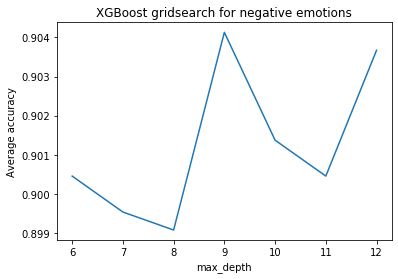

In [37]:
for param_name, param_values in params.items():
    plot_cv_results(negative_model_xgb, param_name, param_values, 'XGBoost gridsearch for negative emotions')

In [31]:
model_filename = 'negative_model_rf_mfcc_' + str(n_mfcc) + '_and_chroma_and_amplitude.sav'

params = {'n_estimators': [19, 21, 22, 23, 24, 25, 26, 27, 28, 29]}

if train_models:
    negative_model_rf = RandomForestClassifier(class_weight='balanced')
    negative_model_rf = train_model(negative_model_rf, params, 
                                    X_negative_train, y_negative_train, models_path, model_filename)
    
    pickle.dump(negative_model_rf, open(os.path.join(models_path, model_filename), 'wb'))

else:
    negative_model_rf = pickle.load(open(os.path.join(models_path, model_filename), 'rb'))
    
print(negative_model_rf.score(X_negative_test, y_negative_test))
negative_preds_rf = negative_model_rf.predict(X_negative_test)
negative_res_rf = pd.DataFrame({'real':y_negative_test, 'predicted':negative_preds_rf})

0.8956043956043956


In [38]:
for param_name, param_values in params.items():
    plot_cv_results(negative_model_rf, param_name, param_values, 'XGBoost gridsearch for negative emotions')

Train on 1744 samples, validate on 436 samples
Epoch 1/40
1744/1744 [==============================] - 127s 73ms/step - loss: 1.0439 - acc: 0.5917 - val_loss: 0.5872 - val_acc: 0.7339
Epoch 2/40
1744/1744 [==============================] - 134s 77ms/step - loss: 0.8593 - acc: 0.6479 - val_loss: 0.5447 - val_acc: 0.7477
Epoch 3/40
1744/1744 [==============================] - 130s 75ms/step - loss: 0.6899 - acc: 0.7041 - val_loss: 0.6375 - val_acc: 0.7362
Epoch 4/40
1744/1744 [==============================] - 130s 74ms/step - loss: 0.5843 - acc: 0.7351 - val_loss: 0.4563 - val_acc: 0.7936
Epoch 5/40
1744/1744 [==============================] - 123s 70ms/step - loss: 0.5309 - acc: 0.7511 - val_loss: 0.5108 - val_acc: 0.7867
Epoch 6/40
1744/1744 [==============================] - 114s 65ms/step - loss: 0.5010 - acc: 0.7735 - val_loss: 0.4928 - val_acc: 0.8005
Epoch 7/40
1744/1744 [==============================] - 113s 65ms/step - loss: 0.4397 - acc: 0.8010 - val_loss: 0.4841 - val_acc: 0

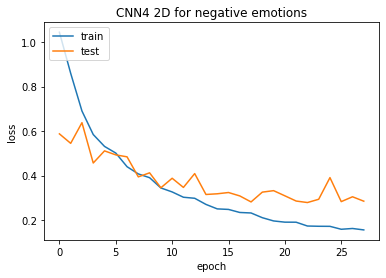

546/546 [==============================] - 13s 23ms/step
Accuracy: 0.9157509157509157
Model saved at negative_model_cnn4_1s_mfcc_12_and_chroma_2d.sav


In [52]:
if compute_2d_mfcc_chroma:
    model_filename = 'negative_model_cnn4_1s_mfcc_' + str(n_mfcc) + '_and_chroma_2d.sav'

    if train_models:
        negative_model_cnn_2d = make_cnn(2, X_2d_train_negative.shape[1], X_2d_train_negative.shape[2], 
                                         input_dimension=2)

        opt = Adam(lr=1e-5, decay=1e-6)
        negative_model_cnn_2d.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        callbacks = [early_stop, ModelCheckpoint(os.path.join(models_path, model_filename),
                                                 monitor='val_loss', 
                                                 save_best_only=True, 
                                                 mode='min',
                                                 verbose=0)]
        negative_history_cnn_2d = negative_model_cnn_2d.fit(X_2d_train_negative, y_2d_train_negative, 
                                                            batch_size=32, epochs=40, validation_split=0.2,
                                                            callbacks=callbacks)
        plot_model_history(negative_history_cnn_2d, 'CNN4 2D for negative emotions')

    else:
        negative_model_cnn_2d = load_model(os.path.join(models_path, model_filename))

    print('Accuracy: {}'.format(negative_model_cnn_2d.evaluate(X_2d_test_negative, y_2d_test_negative)[1]))
    print('Model saved at {}'.format(model_filename))

In [54]:
model_filename = 'positive_model_xgb_1s_mfcc_' + str(n_mfcc) + '_and_chroma_and_amplitude.sav'

params = {'max_depth': [6, 7, 8, 9, 10, 11, 12]}

if train_models:
    positive_model_xgb = XGBClassifier(objective='binary:logistic', learning_rate=0.8)
        
    positive_model_xgb = train_model(positive_model_xgb, params, 
                                     X_positive_train, y_positive_train, models_path, model_filename)


    # save the model to disk
    pickle.dump(positive_model_xgb, open(os.path.join(models_path, model_filename), 'wb'))
    
else:
    positive_model_xgb = pickle.load(open(os.path.join(models_path, model_filename), 'rb'))
    
print(positive_model_xgb.score(X_positive_test, y_positive_test))
positive_preds_xgb = positive_model_xgb.predict(X_positive_test)
positive_res_xgb = pd.DataFrame({'real':y_positive_test, 'predicted':positive_preds_xgb})

0.9776119402985075


In [55]:
for param_name, param_values in params.items():
    plot_cv_results(positive_model_xgb, param_name, param_values, 'XGBoost gridsearch for positive emotions')

In [56]:
model_filename = 'positive_model_rf_1s_mfcc_' + str(n_mfcc) + '_and_chroma_and_amplitude.sav'

params = {'n_estimators': [19, 21, 22, 23, 24, 25, 26, 27, 28, 29]}

if train_models:
    positive_model_rf = RandomForestClassifier(class_weight='balanced')
    positive_model_rf = train_model(positive_model_rf, params, 
                                    X_positive_train, y_positive_train, models_path, model_filename)
    
    pickle.dump(positive_model_rf, open(os.path.join(models_path, model_filename), 'wb'))
    
else:
    positive_model_rf = pickle.load(open(os.path.join(models_path, model_filename), 'rb'))
    
print(positive_model_rf.score(X_positive_test, y_positive_test))
positive_preds_rf = positive_model_rf.predict(X_positive_test)
positive_res_rf = pd.DataFrame({'real':y_positive_test, 'predicted':positive_preds_rf})

0.9832089552238806


In [57]:
for param_name, param_values in params.items():
    plot_cv_results(positive_model_rf, param_name, param_values, 'Random Forest gridsearch for positive emotions')

In [58]:
if compute_2d_mfcc_chroma:
    model_filename = 'positive_model_cnn4_1s_mfcc_' + str(n_mfcc) + '_and_chroma_2d.sav'

    if train_models:
        positive_model_cnn_2d = make_cnn(2, X_2d_train_positive.shape[1], X_2d_train_positive.shape[2], 
                                         input_dimension=2)

        opt = Adam(lr=1e-5, decay=1e-6)
        positive_model_cnn_2d.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        callbacks = [early_stop, ModelCheckpoint(os.path.join(models_path, model_filename),
                                                 monitor='val_loss', 
                                                 save_best_only=True, 
                                                 mode='min',
                                                 verbose=0)]
        positive_history_cnn_2d = negative_model_cnn_2d.fit(X_2d_train_positive, y_2d_train_positive, 
                                                            batch_size=32, epochs=40, validation_split=0.2,
                                                            callbacks=callbacks)
        plot_model_history(positive_history_cnn_2d, 'CNN4 2D for positive emotions')

    else:
        positive_model_cnn_2d = load_model(os.path.join(models_path, model_filename))

    print('Accuracy: {}'.format(positive_model_cnn_2d.evaluate(X_2d_test_positive, y_2d_test_positive)[1]))
    print('Model saved at {}'.format(model_filename))

Train on 1712 samples, validate on 429 samples
Epoch 1/40
1712/1712 [==============================] - 120s 70ms/step - loss: 0.4628 - acc: 0.8125 - val_loss: 0.2714 - val_acc: 0.8928
Epoch 2/40
1712/1712 [==============================] - 114s 67ms/step - loss: 0.2197 - acc: 0.9060 - val_loss: 0.2421 - val_acc: 0.9044
Epoch 3/40
1712/1712 [==============================] - 125s 73ms/step - loss: 0.1791 - acc: 0.9352 - val_loss: 0.1872 - val_acc: 0.9231
Epoch 4/40
1712/1712 [==============================] - 136s 79ms/step - loss: 0.1427 - acc: 0.9451 - val_loss: 0.2046 - val_acc: 0.9114
Epoch 5/40
1712/1712 [==============================] - 167s 97ms/step - loss: 0.1138 - acc: 0.9574 - val_loss: 0.1403 - val_acc: 0.9394
Epoch 6/40
1712/1712 [==============================] - 116s 68ms/step - loss: 0.1008 - acc: 0.9673 - val_loss: 0.1786 - val_acc: 0.9277
Epoch 7/40
1712/1712 [==============================] - 116s 68ms/step - loss: 0.0951 - acc: 0.9685 - val_loss: 0.1745 - val_acc: 0

536/536 [==============================] - 16s 30ms/step
Accuracy: 0.5410447752297814
Model saved at positive_model_cnn4_1s_mfcc_12_and_chroma_2d.sav


In [108]:
def make_prediction(model, x, x_2d, n_labels=2):
    if isinstance(model, Sequential):
        prediction = get_predictions_from_probas(model.predict([x_2d]), n_labels)
    else:
        prediction = model.predict([x])
    return prediction

        
def predict(x, x_2d, model_3labels, model_positive, model_negative):
    prediction = make_prediction(model_3labels, x, x_2d, 3)
        
    if prediction[0] == 3:
        prediction = make_prediction(model_negative, x, x_2d, 2)
    #if prediction[0] == 1:
        #prediction = make_prediction(model_positive, x, x_2d, 2)
        
    return prediction[0]

In [ ]:
inaudible_recordings = recordings_with_features[(recordings_with_features.labels == 2)]
X_pinaudible = np.array(inaudible_recordings.iloc[:,2:])
y_inaudible = np.array(inaudible_recordings.iloc[:,1])
X_inaudible_train, X_inaudible_test, y_inaudible_train, y_inaudible_test = prepare_data(X_inaudible, y_inaudible)

In [75]:
preds_xgb_xgb_positive = []
preds_xgb_rf_positive = []
preds_xgb_cnn2d_positive = []
preds_cnn2d_xgb_positive = []
preds_cnn2d_rf_positive = []
preds_cnn2d_cnn2d_positive = []

for i in range(X_positive_test.shape[0]):
    x = X_positive_test[i]
    x_2d = X_2d_test_positive[i].reshape(1, X_2d_test_positive.shape[1], X_2d_test_positive.shape[2], 1)
    preds_xgb_xgb_positive.append(predict(x, x_2d, 
                                model_xgb, positive_model_xgb, negative_model_xgb))
    preds_xgb_rf_positive.append(predict(x, x_2d, 
                                model_xgb, positive_model_rf, negative_model_rf))
    preds_xgb_cnn2d_positive.append(predict(x, x_2d, 
                                model_xgb, positive_model_cnn_2d, negative_model_cnn_2d))
    preds_cnn2d_xgb_positive.append(predict(x, x_2d, 
                                model_cnn_2d, positive_model_xgb, negative_model_xgb))
    preds_cnn2d_rf_positive.append(predict(x, x_2d, 
                                model_cnn_2d, positive_model_rf, negative_model_rf))
    preds_cnn2d_cnn2d_positive.append(predict(x, x_2d, 
                                model_cnn_2d, positive_model_cnn_2d, negative_model_cnn_2d))

In [81]:
preds_positive = pd.DataFrame({'real': y_positive_test, 
                              'xgb_xgb': preds_xgb_xgb_positive,
                              'xgb_rf': preds_xgb_rf_positive,
                              'xgb_cnn2d': preds_xgb_cnn2d_positive,
                              'cnn2d_xgb': preds_cnn2d_xgb_positive,
                              'cnn2d_rf': preds_cnn2d_rf_positive,
                              'cnn2d_cnn2d': preds_cnn2d_cnn2d_positive})

compare_results(preds_positive, False)
for l in np.unique(preds_positive.real):
    print('\nFor label', labels_dict[int(l)])
    compare_results(preds_positive[preds_positive.real == l], False)

real - xgb_xgb : 89.55223880597015 % similar
real - xgb_rf : 90.11194029850746 % similar
real - xgb_cnn2d : 21.455223880597014 % similar
real - cnn2d_xgb : 89.92537313432835 % similar
real - cnn2d_rf : 90.48507462686567 % similar
real - cnn2d_cnn2d : 21.26865671641791 % similar
xgb_xgb - xgb_rf : 97.76119402985076 % similar
xgb_xgb - xgb_cnn2d : 20.33582089552239 % similar
xgb_xgb - cnn2d_xgb : 91.7910447761194 % similar
xgb_xgb - cnn2d_rf : 90.11194029850746 % similar
xgb_xgb - cnn2d_cnn2d : 19.029850746268657 % similar
xgb_rf - xgb_cnn2d : 20.522388059701495 % similar
xgb_rf - cnn2d_xgb : 90.11194029850746 % similar
xgb_rf - cnn2d_rf : 91.7910447761194 % similar
xgb_rf - cnn2d_cnn2d : 19.21641791044776 % similar
xgb_cnn2d - cnn2d_xgb : 19.58955223880597 % similar
xgb_cnn2d - cnn2d_rf : 19.402985074626866 % similar
xgb_cnn2d - cnn2d_cnn2d : 95.7089552238806 % similar
cnn2d_xgb - cnn2d_rf : 97.76119402985076 % similar
cnn2d_xgb - cnn2d_cnn2d : 21.082089552238806 % similar
cnn2d_rf - cn

In [82]:
preds_xgb_xgb_negative = []
preds_xgb_rf_negative = []
preds_xgb_cnn2d_negative = []
preds_cnn2d_xgb_negative = []
preds_cnn2d_rf_negative = []
preds_cnn2d_cnn2d_negative = []

for i in range(X_negative_test.shape[0]):
    x = X_negative_test[i]
    x_2d = X_2d_test_negative[i].reshape(1, X_2d_test_negative.shape[1], X_2d_test_negative.shape[2], 1)
    preds_xgb_xgb_negative.append(predict(x, x_2d, 
                                model_xgb, positive_model_xgb, negative_model_xgb))
    preds_xgb_rf_negative.append(predict(x, x_2d, 
                                model_xgb, positive_model_rf, negative_model_rf))
    preds_xgb_cnn2d_negative.append(predict(x, x_2d, 
                                model_xgb, positive_model_cnn_2d, negative_model_cnn_2d))
    preds_cnn2d_xgb_negative.append(predict(x, x_2d, 
                                model_cnn_2d, positive_model_xgb, negative_model_xgb))
    preds_cnn2d_rf_negative.append(predict(x, x_2d, 
                                model_cnn_2d, positive_model_rf, negative_model_rf))
    preds_cnn2d_cnn2d_negative.append(predict(x, x_2d, 
                                model_cnn_2d, positive_model_cnn_2d, negative_model_cnn_2d))
    
preds_negative = pd.DataFrame({'real': y_negative_test, 
                              'xgb_xgb': preds_xgb_xgb_negative,
                              'xgb_rf': preds_xgb_rf_negative,
                              'xgb_cnn2d': preds_xgb_cnn2d_negative,
                              'cnn2d_xgb': preds_cnn2d_xgb_negative,
                              'cnn2d_rf': preds_cnn2d_rf_negative,
                              'cnn2d_cnn2d': preds_cnn2d_cnn2d_negative})

compare_results(preds_negative, False)
for l in np.unique(preds_negative.real):
    print('\nFor label', labels_dict[int(l)])
    compare_results(preds_negative[preds_negative.real == l], False)

real - xgb_xgb : 91.39194139194139 % similar
real - xgb_rf : 89.01098901098901 % similar
real - xgb_cnn2d : 0.0 % similar
real - cnn2d_xgb : 89.92673992673993 % similar
real - cnn2d_rf : 87.17948717948718 % similar
real - cnn2d_cnn2d : 0.0 % similar
xgb_xgb - xgb_rf : 93.95604395604396 % similar
xgb_xgb - xgb_cnn2d : 0.3663003663003663 % similar
xgb_xgb - cnn2d_xgb : 96.33699633699634 % similar
xgb_xgb - cnn2d_rf : 90.29304029304029 % similar
xgb_xgb - cnn2d_cnn2d : 0.18315018315018314 % similar
xgb_rf - xgb_cnn2d : 0.3663003663003663 % similar
xgb_rf - cnn2d_xgb : 90.29304029304029 % similar
xgb_rf - cnn2d_rf : 96.33699633699634 % similar
xgb_rf - cnn2d_cnn2d : 0.18315018315018314 % similar
xgb_cnn2d - cnn2d_xgb : 0.18315018315018314 % similar
xgb_cnn2d - cnn2d_rf : 0.5494505494505495 % similar
xgb_cnn2d - cnn2d_cnn2d : 97.8021978021978 % similar
cnn2d_xgb - cnn2d_rf : 92.67399267399267 % similar
cnn2d_xgb - cnn2d_cnn2d : 1.282051282051282 % similar
cnn2d_rf - cnn2d_cnn2d : 1.28205128

In [109]:
data_path_onetreehill = 'onetreehill/'

librosa_features_filename_outofsample = '4labels_librosa_features_' + str(n_mfcc) \
                                            + '_mfcc_onetreehill.pkl'
amplitude_features_filename_outofsample = '4labels_amplitude_onetreehill.pkl'

In [115]:
recordings_librosa_features_outofsample = pd.read_pickle(os.path.join(feature_engineering_path, 
                                                             librosa_features_filename_outofsample))
recordings_amplitude_features_outofsample = pd.read_pickle(os.path.join(feature_engineering_path, 
                                                                            amplitude_features_filename_outofsample))

recordings_outofsample = recordings_librosa_features_outofsample.iloc[:,:26]\
                            .merge(recordings_amplitude_features_outofsample.drop('labels', axis=1), 
                                   on='paths')

X_outofsample = recordings_outofsample.iloc[:,2:].to_numpy()
y_outofsample = recordings_outofsample.iloc[:,1].to_numpy()
print(X_outofsample.shape)

(38, 28)


In [116]:
if compute_2d_mfcc_chroma:
    features_outofsample = recordings_outofsample.paths.apply(extract_2d_features, 
                                                              args=(labelled_data_path, n_mfcc, True)).values

    features_2d_outofsample = np.zeros((features_outofsample.shape[0], 
                                        features_outofsample[0].shape[0], 
                                        features_outofsample[0].shape[1]))
    for i in range(features_outofsample.shape[0]):
        features_2d_outofsample[i] = features_outofsample[i]

    print(features_2d_outofsample.shape)
    
    X_2d_outofsample = np.expand_dims(features_2d_outofsample, axis=3)
    print(X_2d_outofsample.shape)

(38, 24, 44)
(38, 24, 44, 1)


In [117]:
preds_xgb_xgb_outofsample = []
preds_xgb_rf_outofsample = []
preds_xgb_cnn2d_outofsample = []
preds_cnn2d_xgb_outofsample = []
preds_cnn2d_rf_outofsample = []
preds_cnn2d_cnn2d_outofsample = []

for i in range(X_outofsample.shape[0]):
    x = X_outofsample[i]
    x_2d = X_2d_outofsample[i].reshape(1, X_2d_outofsample.shape[1], X_2d_outofsample.shape[2], 1)
    preds_xgb_xgb_outofsample.append(predict(x, x_2d, 
                                model_xgb, positive_model_xgb, negative_model_xgb))
    preds_xgb_rf_outofsample.append(predict(x, x_2d,
                                model_xgb, positive_model_rf, negative_model_rf))
    preds_xgb_cnn2d_outofsample.append(predict(x, x_2d, 
                                model_xgb, positive_model_cnn_2d, negative_model_cnn_2d))
    preds_cnn2d_xgb_outofsample.append(predict(x, x_2d, 
                                model_cnn_2d, positive_model_xgb, negative_model_xgb))
    preds_cnn2d_rf_outofsample.append(predict(x, x_2d, 
                                model_cnn_2d, positive_model_rf, negative_model_rf))
    preds_cnn2d_cnn2d_outofsample.append(predict(x, x_2d, 
                                model_cnn_2d, positive_model_cnn_2d, negative_model_cnn_2d))
    
preds_outofsample = pd.DataFrame({'real': y_outofsample, 
                              'xgb_xgb': preds_xgb_xgb_outofsample,
                              'xgb_rf': preds_xgb_rf_outofsample,
                              'xgb_cnn2d': preds_xgb_cnn2d_outofsample,
                              'cnn2d_xgb': preds_cnn2d_xgb_outofsample,
                              'cnn2d_rf': preds_cnn2d_rf_outofsample,
                              'cnn2d_cnn2d': preds_cnn2d_cnn2d_outofsample})

compare_results(preds_outofsample, False)
for l in np.unique(preds_outofsample.real):
    print('\nFor label', labels_dict[int(l)])
    compare_results(preds_outofsample[preds_outofsample.real == l], False)

real - xgb_xgb : 18.421052631578945 % similar
real - xgb_rf : 18.421052631578945 % similar
real - xgb_cnn2d : 31.57894736842105 % similar
real - cnn2d_xgb : 50.0 % similar
real - cnn2d_rf : 50.0 % similar
real - cnn2d_cnn2d : 55.26315789473685 % similar
xgb_xgb - xgb_rf : 89.47368421052632 % similar
xgb_xgb - xgb_cnn2d : 34.21052631578947 % similar
xgb_xgb - cnn2d_xgb : 57.89473684210527 % similar
xgb_xgb - cnn2d_rf : 50.0 % similar
xgb_xgb - cnn2d_cnn2d : 13.157894736842104 % similar
xgb_rf - xgb_cnn2d : 34.21052631578947 % similar
xgb_rf - cnn2d_xgb : 50.0 % similar
xgb_rf - cnn2d_rf : 57.89473684210527 % similar
xgb_rf - cnn2d_cnn2d : 13.157894736842104 % similar
xgb_cnn2d - cnn2d_xgb : 23.684210526315788 % similar
xgb_cnn2d - cnn2d_rf : 23.684210526315788 % similar
xgb_cnn2d - cnn2d_cnn2d : 68.42105263157895 % similar
cnn2d_xgb - cnn2d_rf : 89.47368421052632 % similar
cnn2d_xgb - cnn2d_cnn2d : 50.0 % similar
cnn2d_rf - cnn2d_cnn2d : 50.0 % similar

For label neutral/happy
real - xg

In [98]:
preds_outofsample

real  xgb_xgb  xgb_rf  xgb_cnn2d  cnn2d_xgb  cnn2d_rf  cnn2d_cnn2d
0    1.0      3.0     3.0        1.0        3.0       3.0            1
1    1.0      3.0     3.0        1.0        3.0       3.0            1
2    3.0      1.0     1.0        1.0        3.0       3.0            2
3    3.0      3.0     3.0        1.0        3.0       3.0            1
4    3.0      3.0     3.0        1.0        3.0       3.0            1
5    3.0      3.0     4.0        2.0        3.0       4.0            2
6    0.0      3.0     3.0        2.0        3.0       3.0            2
7    0.0      3.0     3.0        2.0        3.0       3.0            2
8    0.0      1.0     1.0        1.0        4.0       3.0            2
9    0.0      3.0     3.0        1.0        3.0       3.0            1
10   0.0      4.0     3.0        1.0        4.0       3.0            1
11   0.0      3.0     3.0        1.0        3.0       3.0            1
12   0.0      3.0     4.0        1.0        1.0       1.0            1
13   0.0      3.0     3.0        2.0        3.0       3.0            2
14   0.0      3.0     3.0        1.0        0.0       0.0            2
15   0.0      3.0     3.0        1.0        3.0       3.0            1
16   0.0      3.0     3.0        2.0        3.0       3.0            2
17   4.0      3.0     3.0        1.0        3.0       3.0            1
18   4.0      3.0     3.0        1.0        3.0       3.0            1
19   4.0      3.0     3.0        2.0        3.0       3.0            2
20   4.0      3.0     4.0        2.0        3.0       4.0            2
21   4.0      3.0     3.0        2.0        3.0       3.0            2
22   2.0      0.0     0.0        1.0        2.0       2.0            2
23   2.0      0.0     0.0        1.0        2.0       2.0            2
24   2.0      0.0     0.0        1.0        0.0       0.0            1
25   2.0      0.0     0.0        1.0        0.0       0.0            1
26   2.0      0.0     0.0        1.0        2.0       2.0            2
27   2.0      3.0     3.0        1.0        2.0       2.0            2
28   2.0      3.0     3.0        1.0        1.0       0.0            2
29   2.0      0.0     0.0        1.0        2.0       2.0            2
30   2.0      0.0     0.0        1.0        2.0       2.0            2
31   2.0      3.0     3.0        1.0        1.0       0.0            1
32   2.0      2.0     2.0        2.0        2.0       2.0            2
33   2.0      3.0     3.0        1.0        2.0       2.0            2
34   2.0      0.0     0.0        1.0        2.0       2.0            2
35   2.0      2.0     2.0        2.0        2.0       2.0            2
36   2.0      3.0     3.0        1.0        2.0       2.0            2
37   2.0      4.0     4.0        2.0        4.0       4.0            2
38   2.0      2.0     2.0        2.0        2.0       2.0            2
39   2.0      3.0     3.0        1.0        2.0       2.0            2